In [336]:
import pandas as pd #loading data and applying functions.
import numpy as np

import matplotlib.pyplot as plt #visualizing data
import seaborn as sns #visualizing data

import nltk #cleaning the data 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re
import string 

from sklearn.feature_extraction.text import CountVectorizer # **Import CountVectorizer and create a CountVectorizer object.**
from sklearn.model_selection import train_test_split # Train Test Split
from sklearn.naive_bayes import MultinomialNB # for training a model
from sklearn.metrics import confusion_matrix,classification_report #for Predictions and Evaluations

from collections import Counter  # for counting words of negative reviews
from joblib import dump, load # for Model persistence

# 1. Imports

# 2. Get the Data

In [337]:
df= pd.read_csv(r"C:\Users\allli\Desktop\SDAIA\Project\Data\Women's Fashion Review.csv",index_col=0)

In [338]:
df.head(1) 

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates


In [339]:
df.shape   #representing rows and columns respectively

(23486, 10)

In [340]:
df.info() #exploring the data type and counting the numbers of NonValues

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.

Age: Positive Integer variable of the reviewers age.

Title: String variable for the title of the review.

Review Text: String variable for the review body.

Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

Recommended IND: 1 is recommended, 0 is not recommended.

Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.

Division Name: Categorical name of the product high level division.

Department Name: Categorical name of the product department name.

Class Name: Categorical name of the product class name.`

# 3. EDA

In [341]:
df = df.drop(['Clothing ID', 'Title', 'Positive Feedback Count'], axis=1) #dropping unnecessary columns or features.
df.tail(2) #showing the two last values in the dataframe.

,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name
23484,28,I bought this dress for a wedding i have this ...,3,1,General,Dresses,Dresses
23485,52,This dress in a lovely platinum is feminine an...,5,1,General Petite,Dresses,Dresses


In [342]:
df.rename(
    inplace=True,
    columns={
        "Review Text": "Review_Text",
        'Recommended IND': 'Recommended_IND',
        'Division Name': 'Division_Name',
        'Department Name': 'Department_Name',
        'Class Name': 'Class_Name'
    })

In [343]:
df.isna().sum() #counting the numbers of nullvalues in each column 

Age                  0
Review_Text        845
Rating               0
Recommended_IND      0
Division_Name       14
Department_Name     14
Class_Name          14
dtype: int64

In [344]:
#df.Review_Text = df['Review_Text'].fillna(df['Review_Text'].mode()[0])
#df.Division_Name = df['Division_Name'].fillna(df['Division_Name'].mode()[0])
#df.Department_Name = df['Department_Name'].fillna(df['Department_Name'].mode()[0])
#df.Class_Name = df['Class_Name'].fillna(df['Class_Name'].mode()[0])
df.dropna(subset=['Review_Text','Division_Name', 'Department_Name','Class_Name'], inplace=True)

We are going to drop null rows since we are not able to fill text data.

In [345]:
df.isna().sum()

Age                0
Review_Text        0
Rating             0
Recommended_IND    0
Division_Name      0
Department_Name    0
Class_Name         0
dtype: int64

In [346]:
df.shape #number of rows after droping null values

(22628, 7)

#### 3.1 Visualizing the data

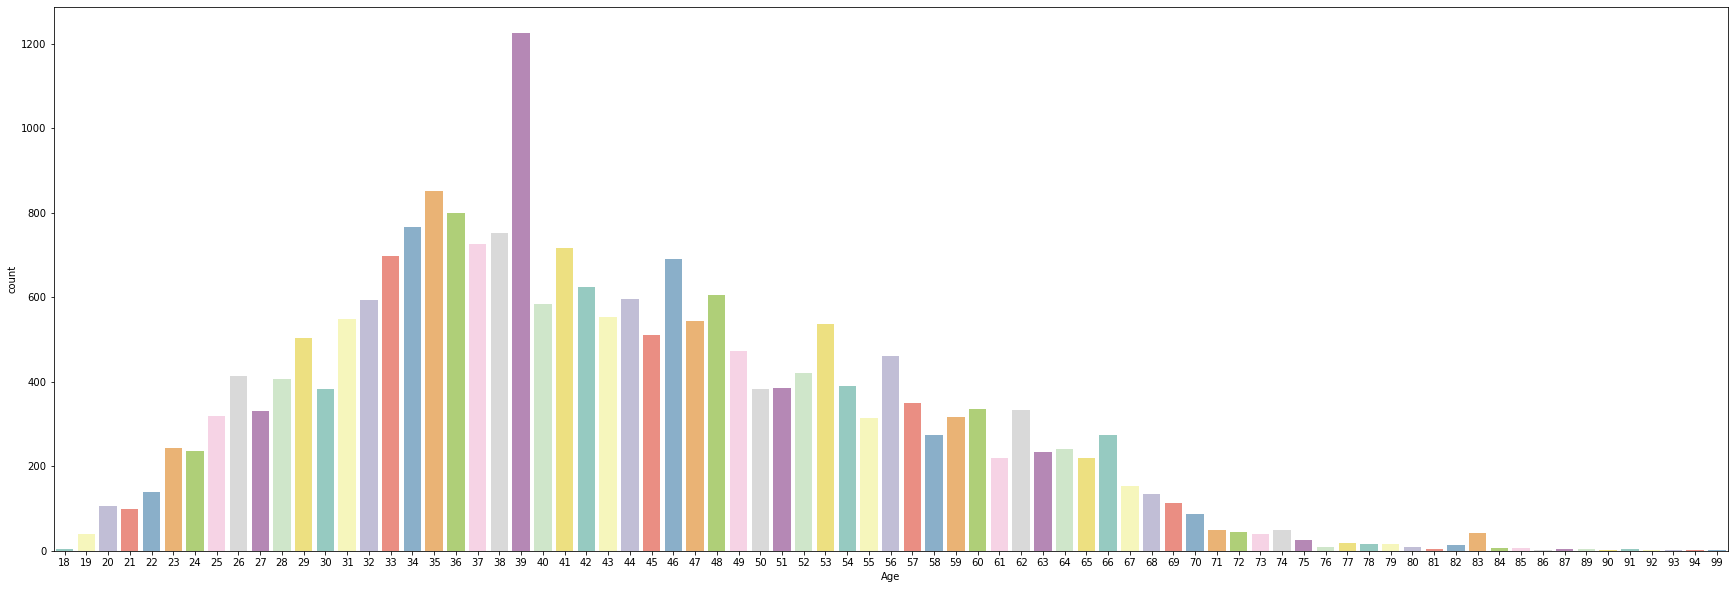

In [347]:
plt.figure(figsize = (30,10))
sns.countplot(x='Age', data=df, palette="Set3")
plt.savefig('Agedistribution.png')


Based on the above graph, most reviews have been posted by customers whose ages are 39, 35, 34,38 respectively, whereas there are some outliers like ages 84 and above. 

<AxesSubplot:xlabel='Rating', ylabel='count'>

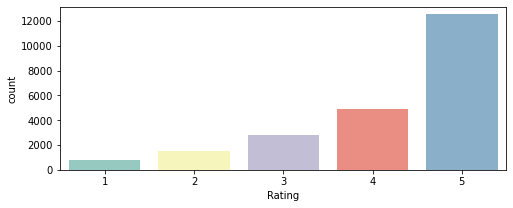

In [348]:
plt.figure(figsize = (8,3))
sns.countplot(x='Rating', data=df, palette="Set3")

([<matplotlib.patches.Wedge at 0x1a745c3c9a0>,
 [Text(0.9264657083553438, 0.5930103635195858, 'Unrecomended'),
  Text(-0.9264656528337023, -0.5930104502615632, 'Recomended')],
 [Text(0.4211207765251562, 0.26955016523617537, '18.1%'),
  Text(-0.4211207512880465, -0.26955020466434687, '81.9%')])

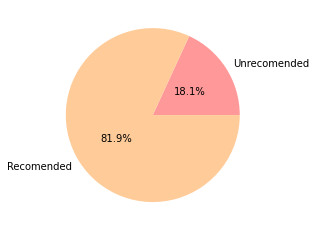

In [349]:
plt.figure(figsize = (8,4))
reun= df.groupby('Recommended_IND')['Recommended_IND'].count()  
plt.pie(x=reun, autopct="%.1f%%",  colors = ['#ff9999','#ffcc99'],labels=['Unrecomended','Recomended'], pctdistance=0.5)

In [350]:
df['Division_Name'].unique()

array(['Initmates', 'General', 'General Petite'], dtype=object)

In [351]:
df['Department_Name'].value_counts()

Tops        10048
Dresses      6145
Bottoms      3662
Intimate     1653
Jackets      1002
Trend         118
Name: Department_Name, dtype: int64

In [352]:
df['Class_Name'].nunique() #number of unique classes

20

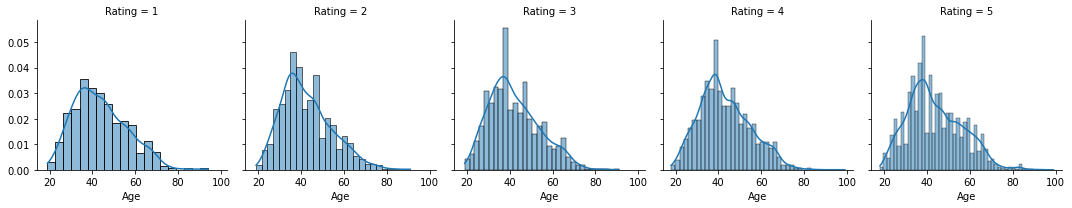

In [353]:
g = sns.FacetGrid(df, col='Rating', sharex=True, sharey=True) #Relationships between Rating & Age
g.map(sns.histplot, 'Age',stat='density', kde=True);
g.savefig('Rating&Age.png')

We can notice that the distribution in each rating shows similar variations between ages, meaning no age group have preferred some products more than others.


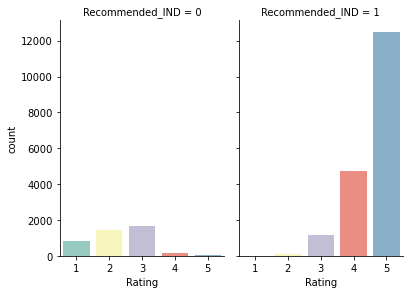

In [354]:
sns.catplot(x="Rating", col="Recommended_IND", data=df,kind="count", height=4, aspect=.7, palette="Set3") #Relationships between Rating & Recommended IND

Clothes with 5 and 4 rating stars have been mostly recommended whereas there was a slight recommendation on proudcts with 1, 2 and 3 rating stars respectively.

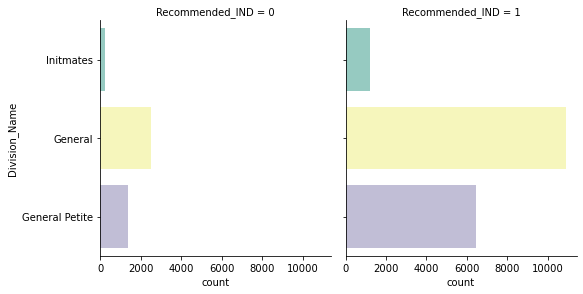

In [355]:
sns.catplot(y="Division_Name", col="Recommended_IND", data=df,kind="count", height=4, palette="Set3") #Relationships between Division Name & Recommended IND

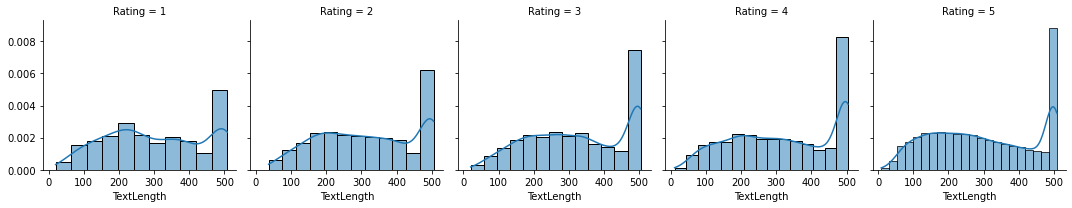

In [356]:
df['TextLength'] = df['Review_Text'].apply(len)
g = sns.FacetGrid(df, col='Rating', sharex=True, sharey=True) #Relationships between Recommended IND & review length
g.map(sns.histplot, 'TextLength',stat='density', kde=True);

We can infer that the length of the text has been similar in distribution among all rating stars.

#### 3.2 Data Preprocessing

In [357]:
lemmatizer = WordNetLemmatizer()
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Removning all punctuation.
    2. Removing all numbers. 
    3. Removing all stopwords and lowring the word.
    4. Removing a word that has length <= 2. 
    5. Returning a cleaned text
    """
    text = ''.join([char for char in text if char not in string.punctuation])
    text=''.join((i for i in text if not i.isdigit()))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    text= [j for j in text if len(j) > 3] # remove word if its ength>3
   
    
    text = ' '.join([lemmatizer.lemmatize(word) for word in text])

    return text

In [358]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [359]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [360]:
df["CleanText"] = df["Review_Text"].apply(text_process)

In [361]:
df.duplicated().sum()

6

In [362]:
df.drop_duplicates()

,Age,Review_Text,Rating,Recommended_IND,Division_Name,Department_Name,Class_Name,TextLength,CleanText
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,53,Absolutely wonderful silky sexy comfortable
1,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,303,Love dress sooo pretty happened find store gla...
2,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses,500,high hope dress really wanted work initially o...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,124,love love love jumpsuit flirty fabulous every ...
4,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,192,shirt flattering adjustable front perfect leng...
...,...,...,...,...,...,...,...,...,...
23481,34,I was very happy to snag this dress at such a ...,5,1,General Petite,Dresses,Dresses,131,happy snag dress great price easy slip flatter...
23482,48,"It reminds me of maternity clothes. soft, stre...",3,1,General Petite,Tops,Knits,223,reminds maternity clothes soft stretchy shiny ...
23483,31,"This fit well, but the top was very see throug...",3,0,General Petite,Dresses,Dresses,208,well never would worked glad able store didnt ...
23484,28,I bought this dress for a wedding i have this ...,3,1,General,Dresses,Dresses,427,bought dress wedding summer cute unfortunately...


# 4. NLP Task

#### 4.1 Feature Extraction

#### 4.1.1 labeling data

In [363]:
df['Rating_Category']=df["Rating"].apply(lambda x:"Dissatisfied" if (x==1 or x==2) else ( 'Moderate' if x == 3 else 'Satisfied'))
df.head(1)

,Age,Review_Text,Rating,Recommended_IND,Division_Name,Department_Name,Class_Name,TextLength,CleanText,Rating_Category
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,53,Absolutely wonderful silky sexy comfortable,Satisfied


In [364]:
Dec = {"Satisfied": 1, "Moderate": -1, "Dissatisfied": 0}
df["Sentiment"] = df["Rating_Category"].map(Dec)

In [365]:
df['Rating_Category'].value_counts() 

Satisfied       17435
Moderate         2823
Dissatisfied     2370
Name: Rating_Category, dtype: int64

In [366]:
NLP=df
NLP=NLP[NLP['Rating_Category'] != 'Moderate'] # drop moderate reviews rows, so -1 will be dropped

y=NLP.Sentiment  
X=NLP.CleanText

In [367]:
dissreviews=NLP
dissreviews=dissreviews[dissreviews['Sentiment'] == 0] #just showing dissatisfying reviews 
vectorizer = CountVectorizer()

matrix = vectorizer.fit_transform(dissreviews['CleanText'])
counts = pd.DataFrame(matrix.toarray(),
                      columns=vectorizer.get_feature_names())

# Show us the top 10 most common words
counts.T.sort_values(by=0, ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,...,2360,2361,2362,2363,2364,2365,2366,2367,2368,2369
dress,4,0,0,0,0,0,0,0,0,0,...,1,0,4,0,0,5,0,0,1,0
love,2,0,0,0,0,1,1,0,1,0,...,1,1,0,0,0,0,1,0,0,0
skirt,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
wear,1,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,2,0,0
tall,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
narrowing,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
garment,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
stranger,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pretty,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
small,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [368]:
df['TextLengthClean'] = df['CleanText'].apply(len)

#### 4.2 Visualizing the data

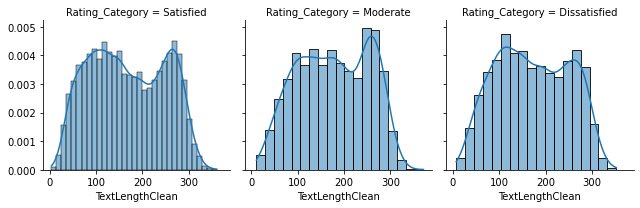

In [369]:
g = sns.FacetGrid(df, col='Rating_Category', sharex=True, sharey=True) #Relationships between Recommended IND & review length
g.map(sns.histplot, 'TextLengthClean',stat='density', kde=True);

#### We can notice that the length of reviews has shrunk after cleaning since the maximum length of  reviews is around 350, while before cleaning it has been around 530. 

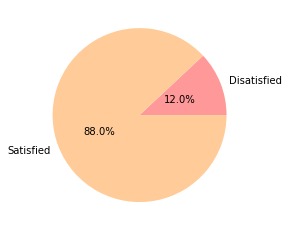

In [370]:
plt.figure(figsize = (8,4))
reun= NLP.groupby('Rating_Category')['Rating_Category'].count()  
plt.pie(x=reun, autopct="%.1f%%",  colors = ['#ff9999','#ffcc99'],labels=['Disatisfied','Satisfied'], pctdistance=0.5)
plt.savefig('PostiveNegative.png')

##### As we can see , we have imbalanced data Satisfying reviews 88.0% and Dissatisfying reviews are 12.0%

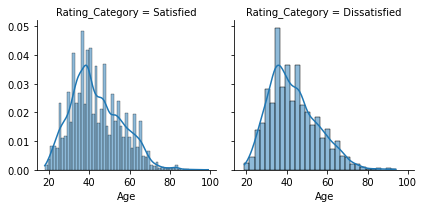

In [371]:
g = sns.FacetGrid(NLP, col='Rating_Category', sharex=True, sharey=True) #Relationships between Rating & Age
g.map(sns.histplot, 'Age',stat='density', kde=True);

##### We can notice that the distribution in two ratings shows similar variations between ages, meaning no age group have preferred some products more than others.

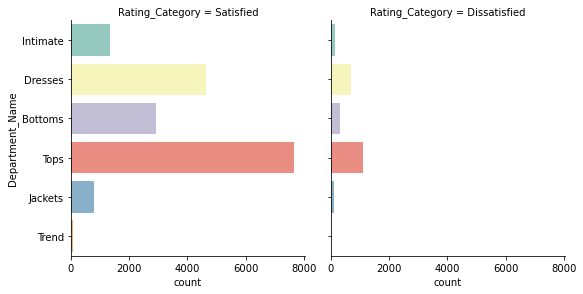

In [372]:
s=sns.catplot(y="Department_Name", col="Rating_Category", data=NLP,kind="count", height=4, palette="Set3") #Relationships between Division Name & Recommended IND
s

In [373]:
s.savefig('bestitems.png')

##### According to two the above graphs, most selling and recommended clothes are tops, dresses and bottoms

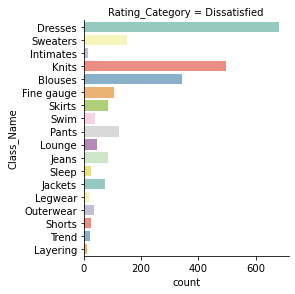

In [374]:
sns.catplot(y="Class_Name", col="Rating_Category", data=dissreviews,kind="count", height=4, palette="Set3") #Relationships between Division Name & Recommended IND

#####  Most customers have been dissatisfied with three itmes which are dresses, knits and blouses.

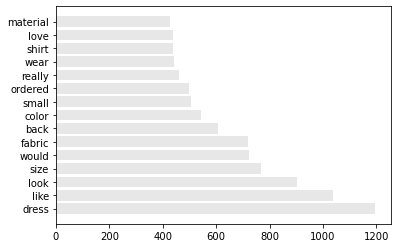

In [375]:
p = Counter(" ".join(dissreviews['CleanText']).split()).most_common(15)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])
plt.barh(rslt['Word'],rslt['Frequency'], color=(0.1, 0.1, 0.1, 0.1));
plt.savefig('commonwords.png')

The graph illustrates 15 common words in reviews which might imply several things. 
1. (dress, shirt, wear) complaining about dresses and shirts.
2. (size, small, wear)  complaining about sizes, so USA and UKA size chart should be included. 
3. (Fabric, Material) complaining about quality, so types of fabric should be included in detail. 
4.(looked, look, like , love). not excepting as in picture, so High resolution image should be posted. 

#### 4.3 creatting  a CountVectorizer object.

In [384]:
cv = CountVectorizer() #Convert a each review to a matrix

In [377]:
X = cv.fit_transform(X)

#### 4.4 Trainning, Testing and Splitting 

In [378]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=101)

#### 4.5 Training a Model

In [379]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

C:\Users\allli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### 4.6 Predictions and Evaluations

In [380]:
predictions = lr.predict(X_test)

In [381]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[ 262  172]
 [ 102 3425]]


              precision    recall  f1-score   support

           0       0.72      0.60      0.66       434
           1       0.95      0.97      0.96      3527

    accuracy                           0.93      3961
   macro avg       0.84      0.79      0.81      3961
weighted avg       0.93      0.93      0.93      3961



In [383]:
dump(nb, 'ModelPresistence/onlineReviews.joblib')  # for model persistence

['ModelPresistence/onlineReviews.joblib']